In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [14]:
import json
import urllib
from collections import defaultdict
from glob import glob
from math import log

import einops
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import mixture
import utils

plt.style.use("seaborn-whitegrid")

/tmp/ipykernel_381327/1081018790.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
dataset_train = utils.dataset.ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-train.csv"
)

dataset_valid = utils.dataset.ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-valid.csv"
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, 128)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, 128)

In [4]:
result = defaultdict(list)
for k, directory in enumerate(sorted(glob("outputs/mixture/*params.pt")), 1):
    params = torch.load(directory)
    params = torch.nn.ParameterDict(params).cpu()
    model = mixture.CategoricalMixture(params)

    log_likelihood, size_data = 0, 0
    with torch.inference_mode():
        for inputs in dataloader_train:
            log_likelihood += model(inputs).sum()
            size_data += inputs.size(0)

    size_params = sum(p.numel() for p in params.parameters())
    nll_avg = log_likelihood.neg() / size_data
    bic = log_likelihood - size_params / 2 * log(size_data)

    result["directory"].append(directory)
    result["nll_avg"].append(nll_avg.round(decimals=4).item())
    result["bic"].append(bic.round(decimals=4).item())
    result["subset"].append("Train")

    log_likelihood, size_data = 0, 0
    with torch.inference_mode():
        for inputs in dataloader_valid:
            log_likelihood += model(inputs).sum()
            size_data += inputs.size(0)

    size_params = sum(p.numel() for p in params.parameters())
    nll_avg = log_likelihood.neg() / size_data
    bic = log_likelihood - size_params / 2 * log(size_data)

    result["directory"].append(directory)
    result["nll_avg"].append(nll_avg.round(decimals=4).item())
    result["bic"].append(bic.round(decimals=4).item())
    result["subset"].append("Validation")

df_result = pd.DataFrame(result)
df_result_train = df_result[df_result.subset == "Train"].reset_index(drop=True)
df_result_valid = df_result[df_result.subset == "Validation"].reset_index(drop=True)
i_best = df_result_train.bic.argmax()

In [5]:
df_result_train.to_csv("outputs/mixture/train-eval.csv", index=False)
df_result_valid.to_csv("outputs/mixture/valid-eval.csv", index=False)
display(df_result_train.head())
display(df_result_valid.head())

,directory,nll_avg,bic,subset
0,outputs/mixture/mixture-01-params.pt,14.8021,-1764455.375,Train
1,outputs/mixture/mixture-02-params.pt,14.0152,-1684921.375,Train
2,outputs/mixture/mixture-03-params.pt,13.7305,-1664804.375,Train
3,outputs/mixture/mixture-04-params.pt,13.5100,-1652281.125,Train
4,outputs/mixture/mixture-05-params.pt,13.3492,-1646819.375,Train


,directory,nll_avg,bic,subset
0,outputs/mixture/mixture-01-params.pt,14.9431,-84599.507812,Validation
1,outputs/mixture/mixture-02-params.pt,14.1687,-90611.726562,Validation
2,outputs/mixture/mixture-03-params.pt,13.8823,-99063.992188,Validation
3,outputs/mixture/mixture-04-params.pt,13.6607,-107840.125000,Validation
4,outputs/mixture/mixture-05-params.pt,13.5085,-116963.593750,Validation


In [6]:
df_result_train

,directory,nll_avg,bic,subset
0,outputs/mixture/mixture-01-params.pt,14.8021,-1764455.375,Train
1,outputs/mixture/mixture-02-params.pt,14.0152,-1684921.375,Train
2,outputs/mixture/mixture-03-params.pt,13.7305,-1664804.375,Train
3,outputs/mixture/mixture-04-params.pt,13.5100,-1652281.125,Train
4,outputs/mixture/mixture-05-params.pt,13.3492,-1646819.375,Train
5,outputs/mixture/mixture-06-params.pt,13.2642,-1650310.375,Train
6,outputs/mixture/mixture-07-params.pt,13.1678,-1652472.000,Train
7,outputs/mixture/mixture-08-params.pt,13.1108,-1659287.000,Train
8,outputs/mixture/mixture-09-params.pt,13.0182,-1661889.750,Train
9,outputs/mixture/mixture-10-params.pt,12.9732,-1670121.500,Train


In [7]:
df_result_valid

,directory,nll_avg,bic,subset
0,outputs/mixture/mixture-01-params.pt,14.9431,-84599.507812,Validation
1,outputs/mixture/mixture-02-params.pt,14.1687,-90611.726562,Validation
2,outputs/mixture/mixture-03-params.pt,13.8823,-99063.992188,Validation
3,outputs/mixture/mixture-04-params.pt,13.6607,-107840.125000,Validation
4,outputs/mixture/mixture-05-params.pt,13.5085,-116963.593750,Validation
5,outputs/mixture/mixture-06-params.pt,13.4244,-126427.250000,Validation
6,outputs/mixture/mixture-07-params.pt,13.3360,-135869.671875,Validation
7,outputs/mixture/mixture-08-params.pt,13.2773,-145459.953125,Validation
8,outputs/mixture/mixture-09-params.pt,13.1877,-154896.203125,Validation
9,outputs/mixture/mixture-10-params.pt,13.1551,-164617.468750,Validation


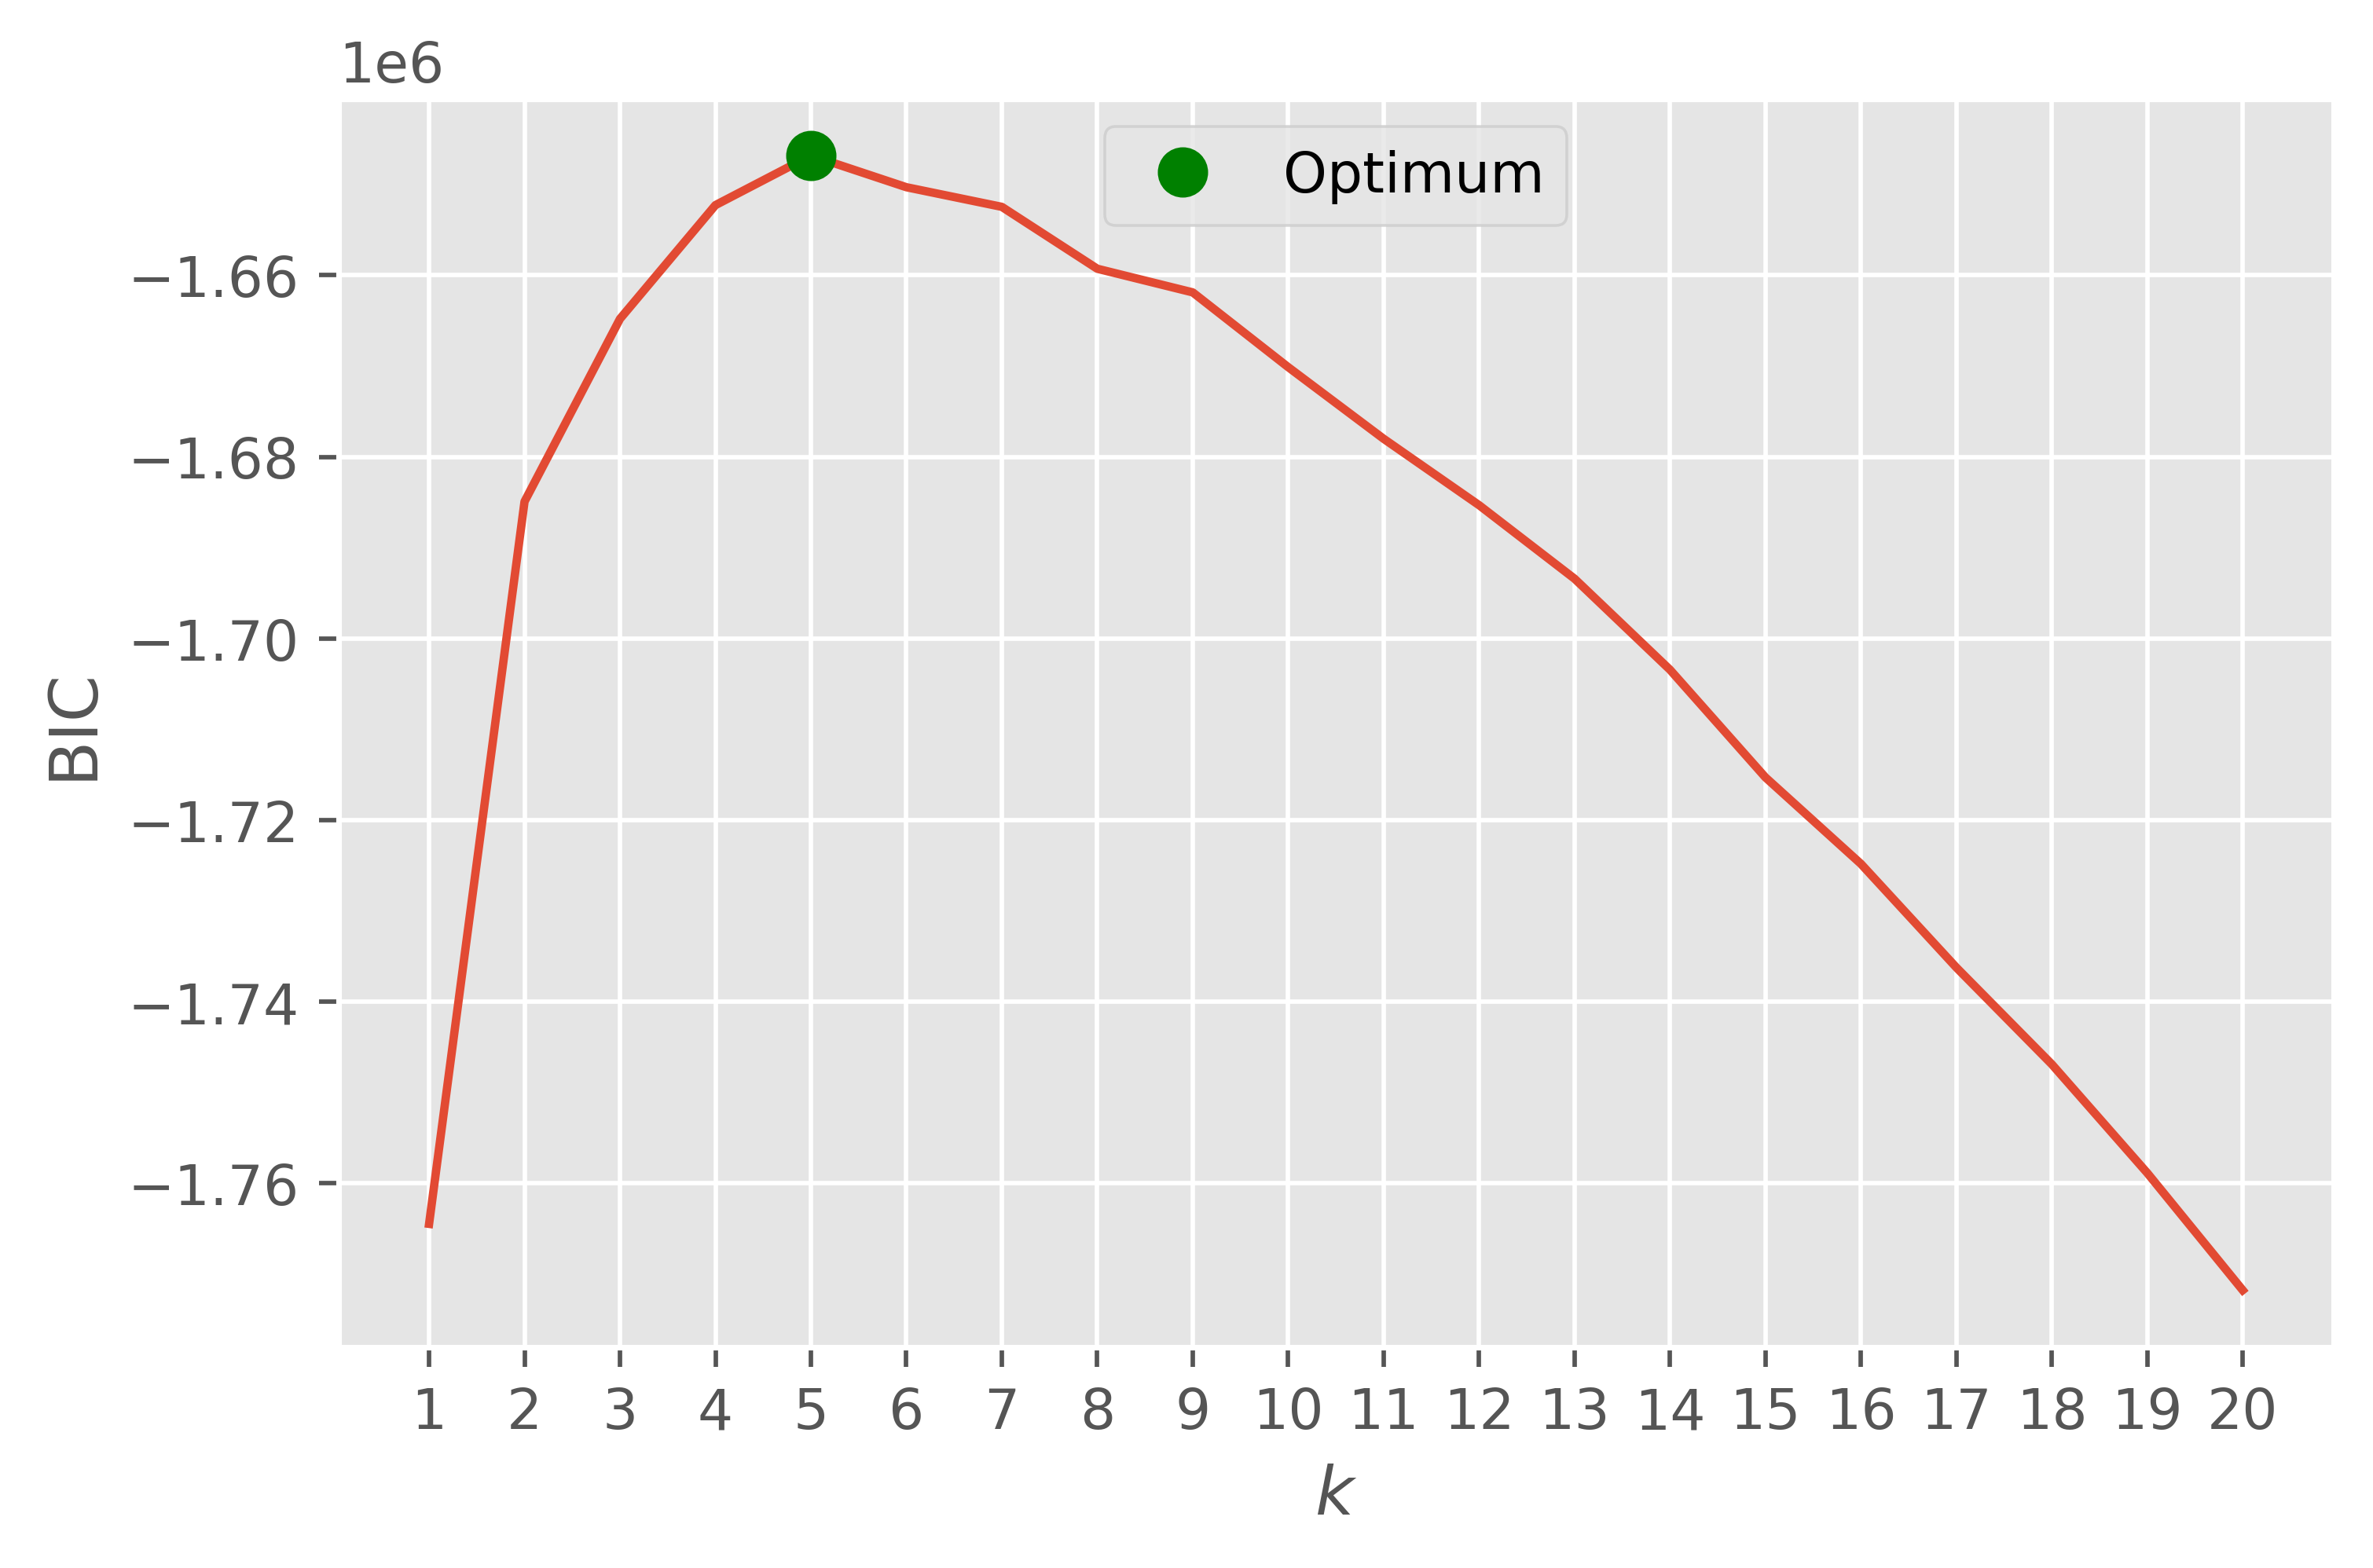

In [8]:
fig = plt.figure(figsize=(6, 4), dpi=512)
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(
    df_result_train,
    x=range(1, df_result_valid.shape[0] + 1),
    y="bic",
    ax=ax,
)
ax.plot(
    i_best + 1,
    df_result_train["bic"][i_best],
    ".",
    label="Optimum",
    markersize=16,
    color="g",
)
ax.set_ylabel("BIC")
ax.set_xlabel("$k$")
ax.set_xticks(range(1, df_result_valid.shape[0] + 1))
ax.legend(loc="upper center")
fig.tight_layout()
fig.savefig("outputs/mixture/bic.pdf")

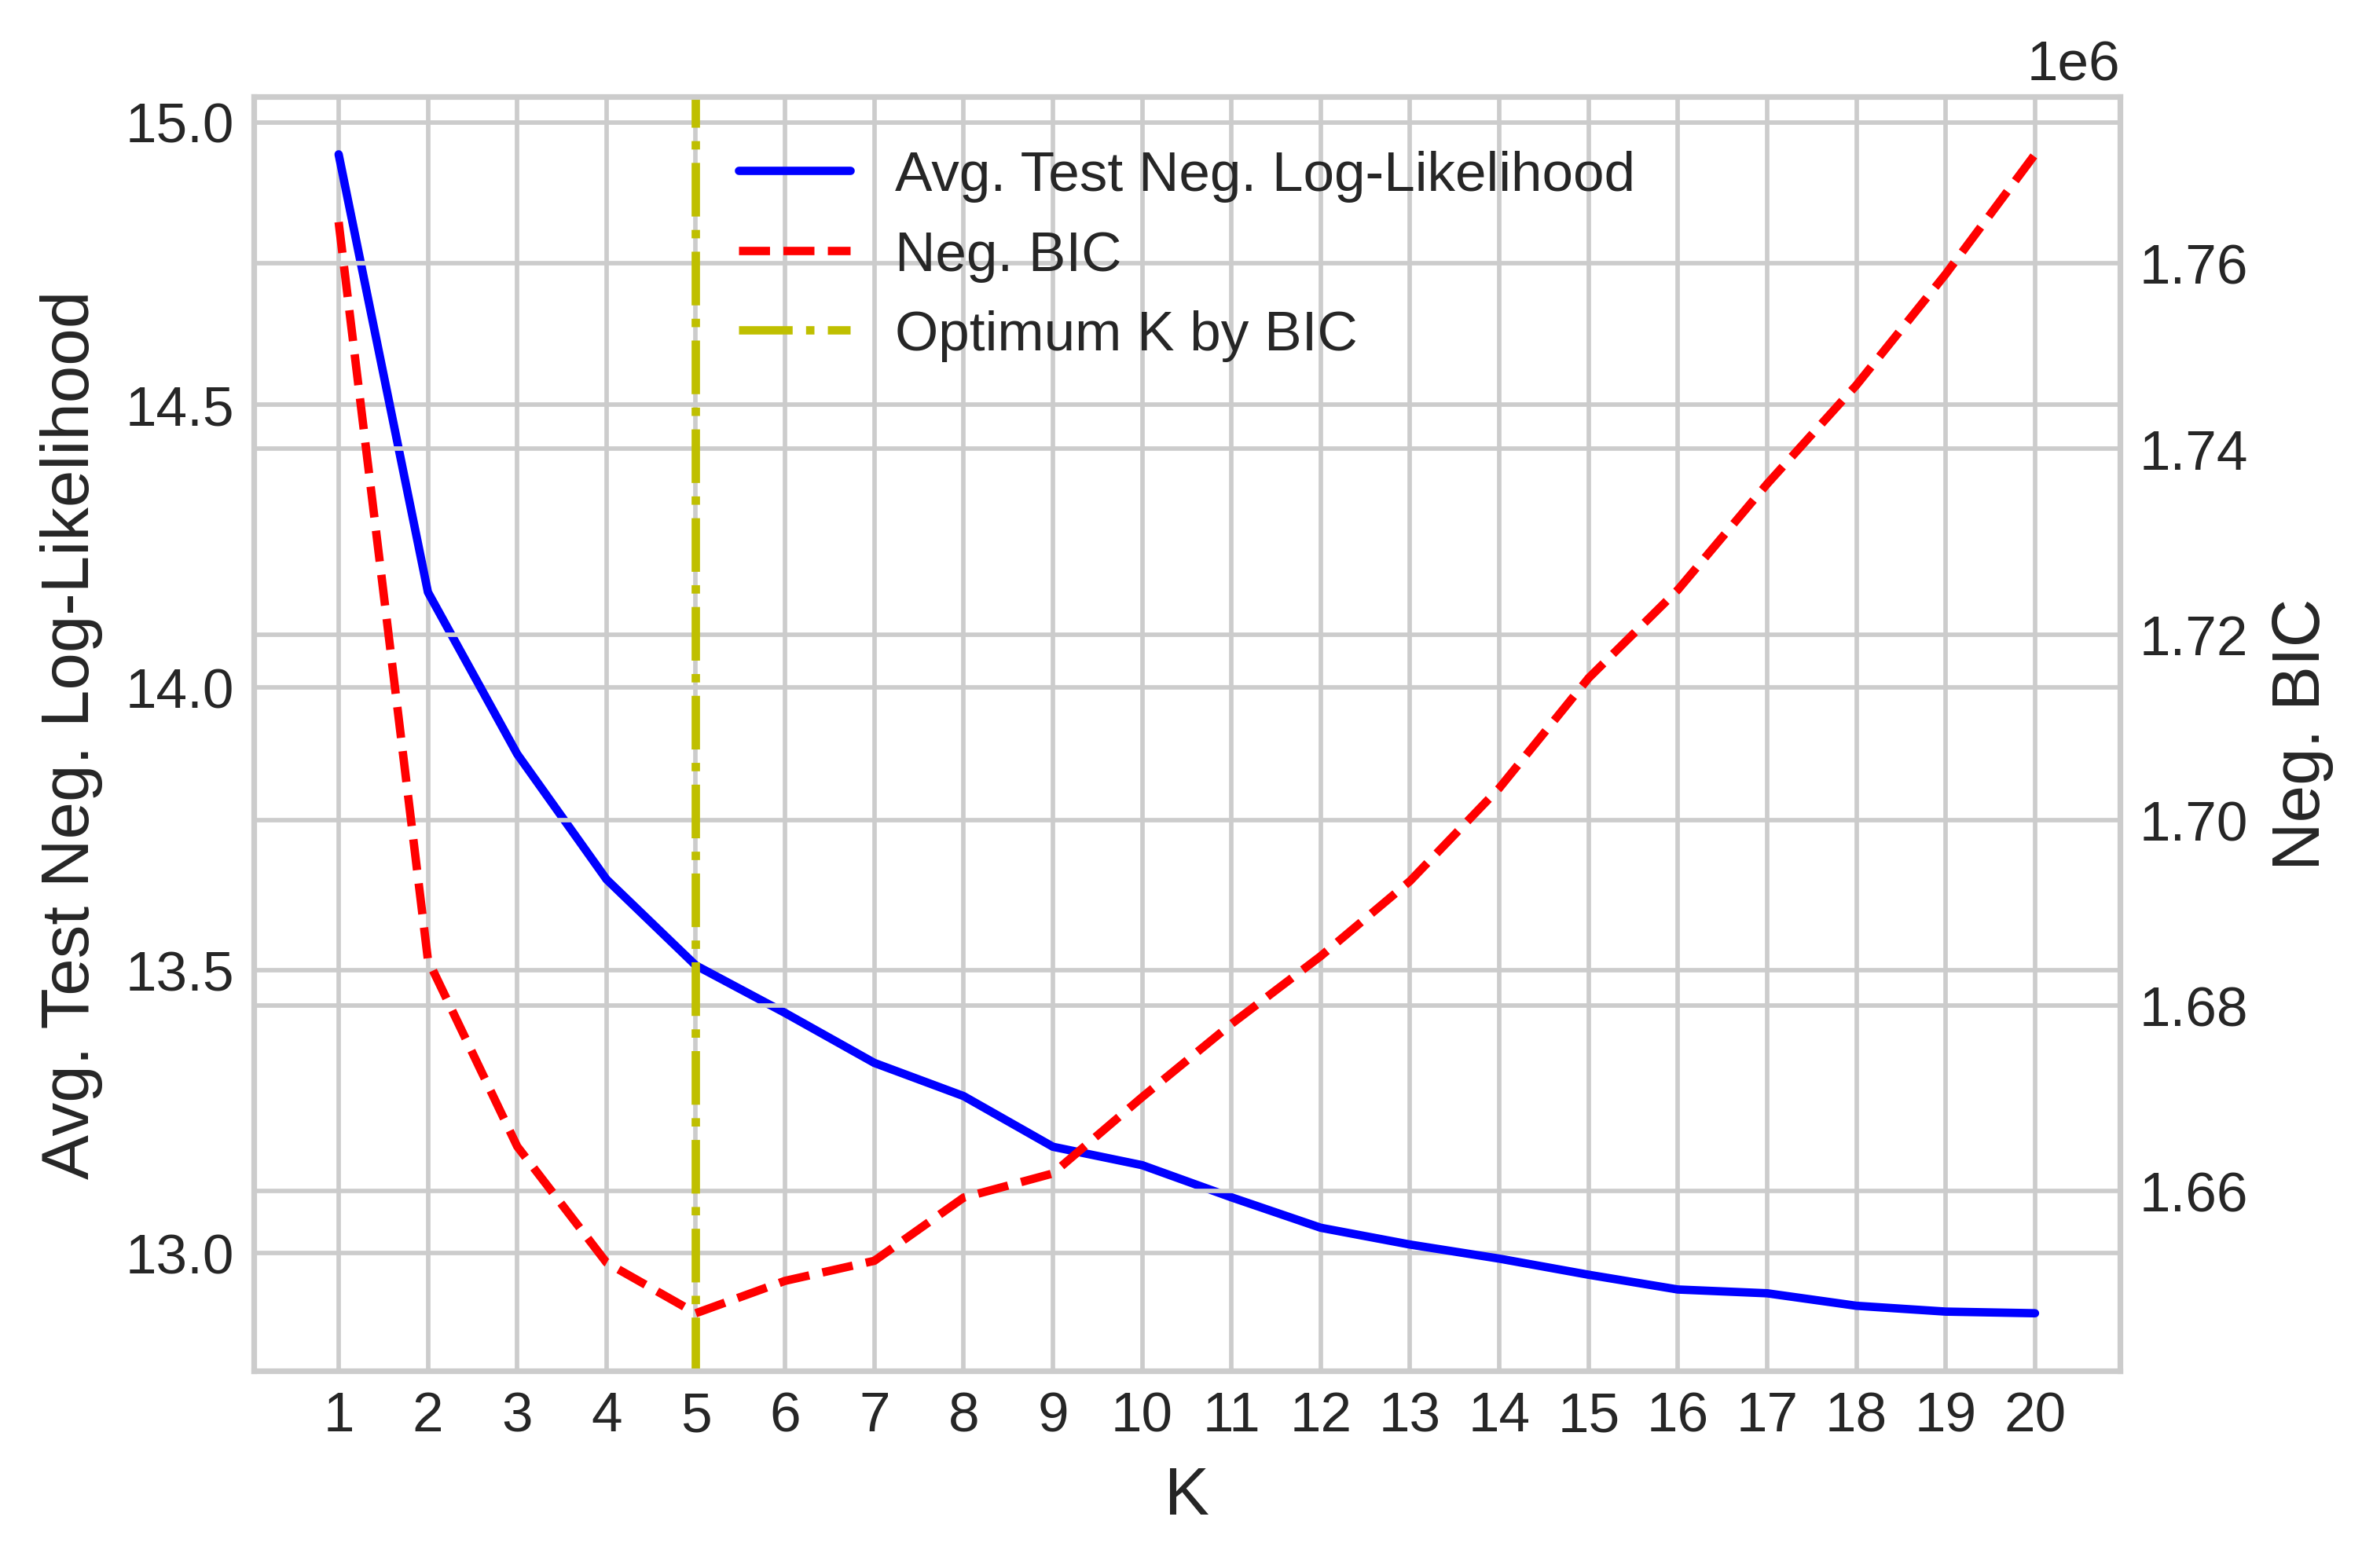

In [16]:
bic_nll = pd.DataFrame(
    {
        "Avg. Test Neg. Log-Likelihood": df_result_valid["nll_avg"].values,
        "Neg. BIC": -df_result_train["bic"].values,
    }
)
bic_nll["K"] = range(1, 21)

fig = plt.figure(figsize=(6, 4), dpi=512)

ax1 = fig.gca()
sns.lineplot(
    data=bic_nll,
    x="K",
    y="Avg. Test Neg. Log-Likelihood",
    color="b",
    ax=ax1,
    label="Avg. Test Neg. Log-Likelihood",
)
ax1.legend_ = None

ax2 = ax1.twinx()
sns.lineplot(
    data=bic_nll,
    x="K",
    y="Neg. BIC",
    linestyle="--",
    color="r",
    ax=ax2,
    label="Neg. BIC",
)
ax2.axvline(bic_nll["K"][4], ls="-.", label="Optimum K by BIC", color="y")
ax2.legend_ = None

ax1.set_xticks(range(1, df_result_valid.shape[0] + 1))

fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0.925))

fig.tight_layout()
fig.savefig("outputs/mixture/scaling.pdf")

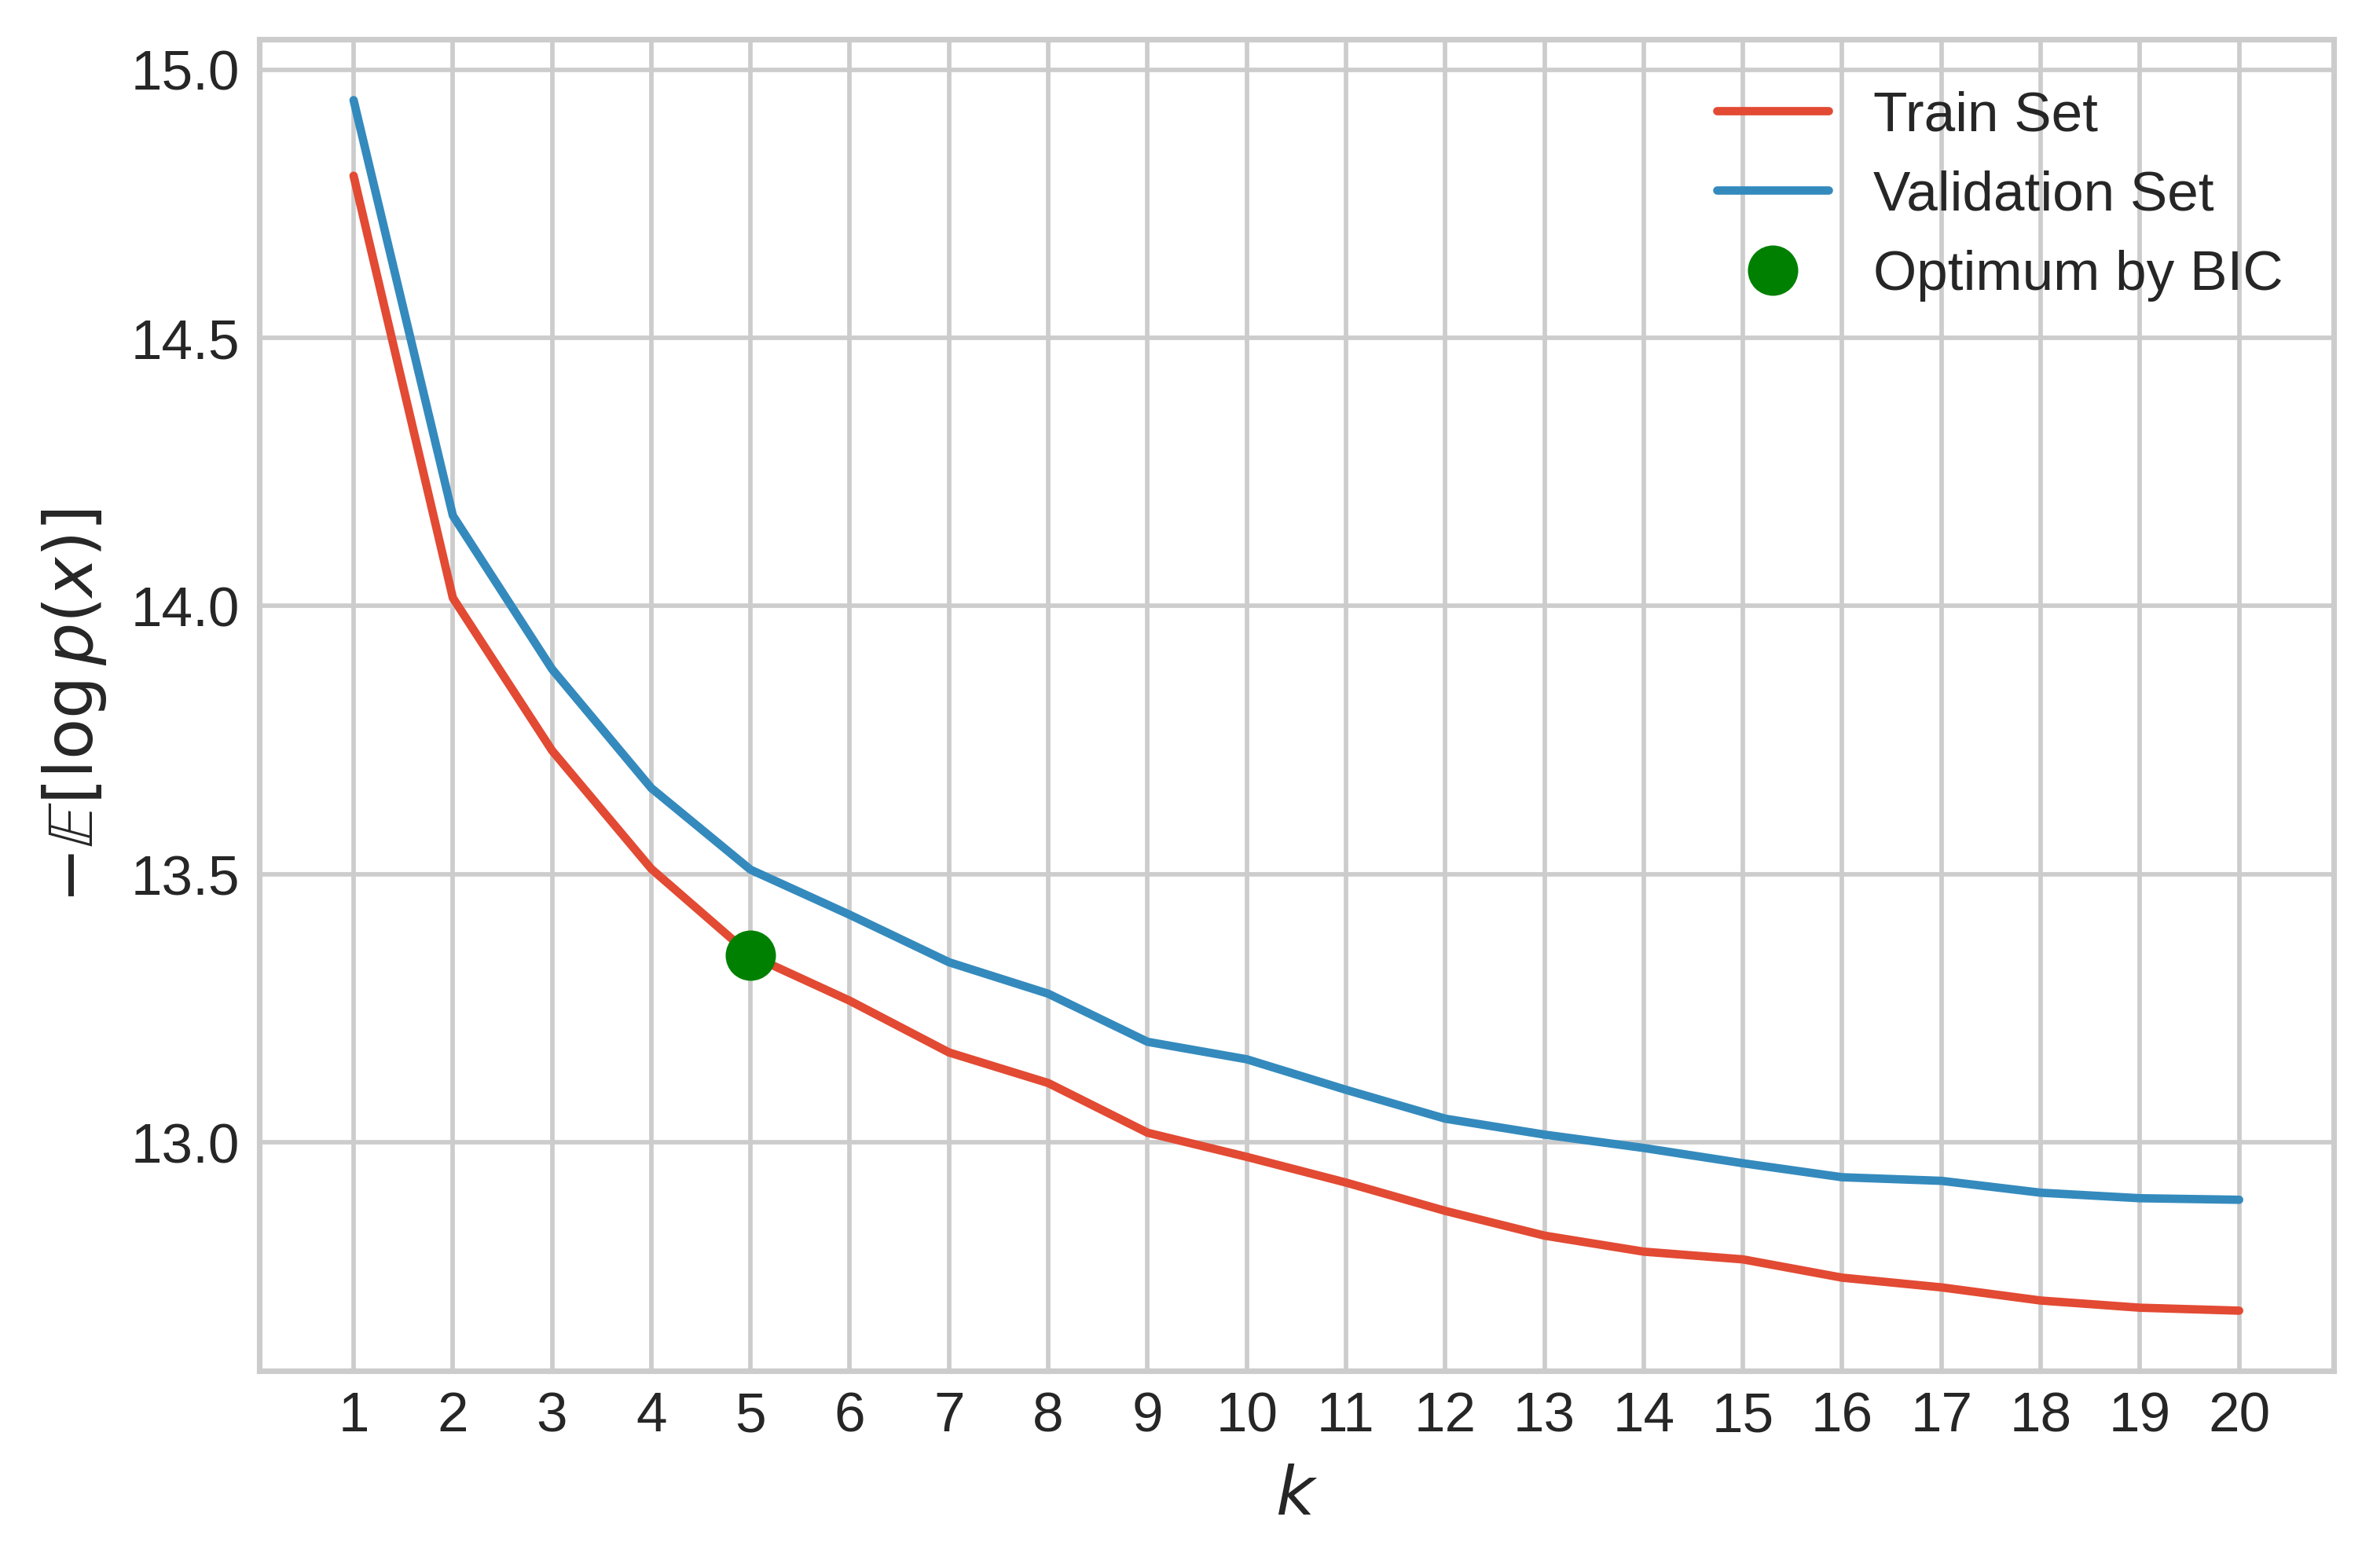

In [15]:
fig = plt.figure(figsize=(6, 4), dpi=512)
ax = fig.add_subplot(1, 1, 1)
sns.lineplot(
    df_result_train,
    x=range(1, df_result_valid.shape[0] + 1),
    y="nll_avg",
    ax=ax,
    label="Train Set",
)
sns.lineplot(
    df_result_valid,
    x=range(1, df_result_valid.shape[0] + 1),
    y="nll_avg",
    ax=ax,
    label="Validation Set",
)
ax.plot(
    i_best + 1,
    df_result_train["nll_avg"][i_best],
    ".",
    label="Optimum by BIC",
    markersize=16,
    color="g",
)

ax.set_ylabel("$-\mathbb{E}[\log p(x)]$")
ax.set_xlabel("$k$")
ax.set_xticks(range(1, df_result_valid.shape[0] + 1))

ax.legend(loc="upper right")
fig.tight_layout()
fig.savefig("outputs/mixture/nll.pdf")

In [12]:
params_best = torch.load(df_result_valid["directory"][i_best])
model = mixture.CategoricalMixture(params_best).cpu()

log_prior = model.dist.mixture_distribution.probs.log()

log_likelihoods = []
groups = []
confidence = []
with torch.inference_mode():
    for inputs in dataloader_valid:
        log_likelihoods.append(model(inputs))
        inputs = einops.repeat(inputs, "n d -> n 1 d")
        log_likelihood = model.dist.component_distribution.log_prob(inputs)
        log_posterior = log_prior + log_likelihood
        posterior = log_posterior.softmax(-1)
        max_a_posteriori = posterior.max(-1)
        groups.append(max_a_posteriori.indices)
        confidence.append(max_a_posteriori.values)
log_likelihood = torch.cat(log_likelihoods).numpy()
groups = torch.cat(groups).numpy()
confidence = torch.cat(confidence).numpy()

In [13]:
df_valid = pd.DataFrame(
    dict(group=groups, log_likelihood=log_likelihood, confidence=confidence),
    columns=["group", "log_likelihood", "confidence"],
)
df_valid = pd.concat([df_valid, dataset_valid.data], axis=1)

In [14]:
np.random.seed(0)
for group in sorted(df_valid.group.unique()):
    sample = (
        df_valid[df_valid.group == group]
        .sort_values("confidence", ascending=False)
        .iloc[:100]
        .sample(16, replace=False, random_state=0)
        .coco_url
    )
    imgs = [[] for i in range(int(16**0.5))]
    for i, url in enumerate(sample):
        img = Image.open(urllib.request.urlopen(sample.iloc[i]))
        img = np.array(img.resize((512, 512)).convert("RGB"))
        imgs[i % len(imgs)].append(img)
    imgs = np.concatenate([np.concatenate(images, 1) for images in imgs], 0)
    imgs = Image.fromarray(imgs)
    imgs.save(f"outputs/mixture/group-{group+1:0=2d}.pdf")

In [15]:
params_best = torch.load(df_result_valid["directory"][0])
model = mixture.CategoricalMixture(params_best).cpu()

max_value = model.dist.component_distribution.base_dist.probs.size(-1)
with torch.inference_mode():
    probs = model.dist.component_distribution.base_dist.probs
    expected_value = (torch.arange(max_value) * probs).sum(-1)
df_expected_value = pd.DataFrame(expected_value, columns=dataset_train.features.columns)
df_expected_value.columns = [
    col.split("-")[0].replace("[", "").replace("]", "").title()
    for col in df_expected_value.columns
]

df_expected_value.to_csv(f"outputs/mixture/expected-value-{1:0=2d}.csv", index=False)

In [16]:
params_best = torch.load(df_result_valid["directory"][19])
model = mixture.CategoricalMixture(params_best).cpu()

max_value = model.dist.component_distribution.base_dist.probs.size(-1)
with torch.inference_mode():
    probs = model.dist.component_distribution.base_dist.probs
    expected_value = (torch.arange(max_value) * probs).sum(-1)
df_expected_value = pd.DataFrame(expected_value, columns=dataset_train.features.columns)
df_expected_value.columns = [
    col.split("-")[0].replace("[", "").replace("]", "").title()
    for col in df_expected_value.columns
]

df_expected_value.to_csv(f"outputs/mixture/expected-value-{20:0=2d}.csv", index=False)

/tmp/ipykernel_381327/797240690.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_expected_value.columns, rotation="vertical")


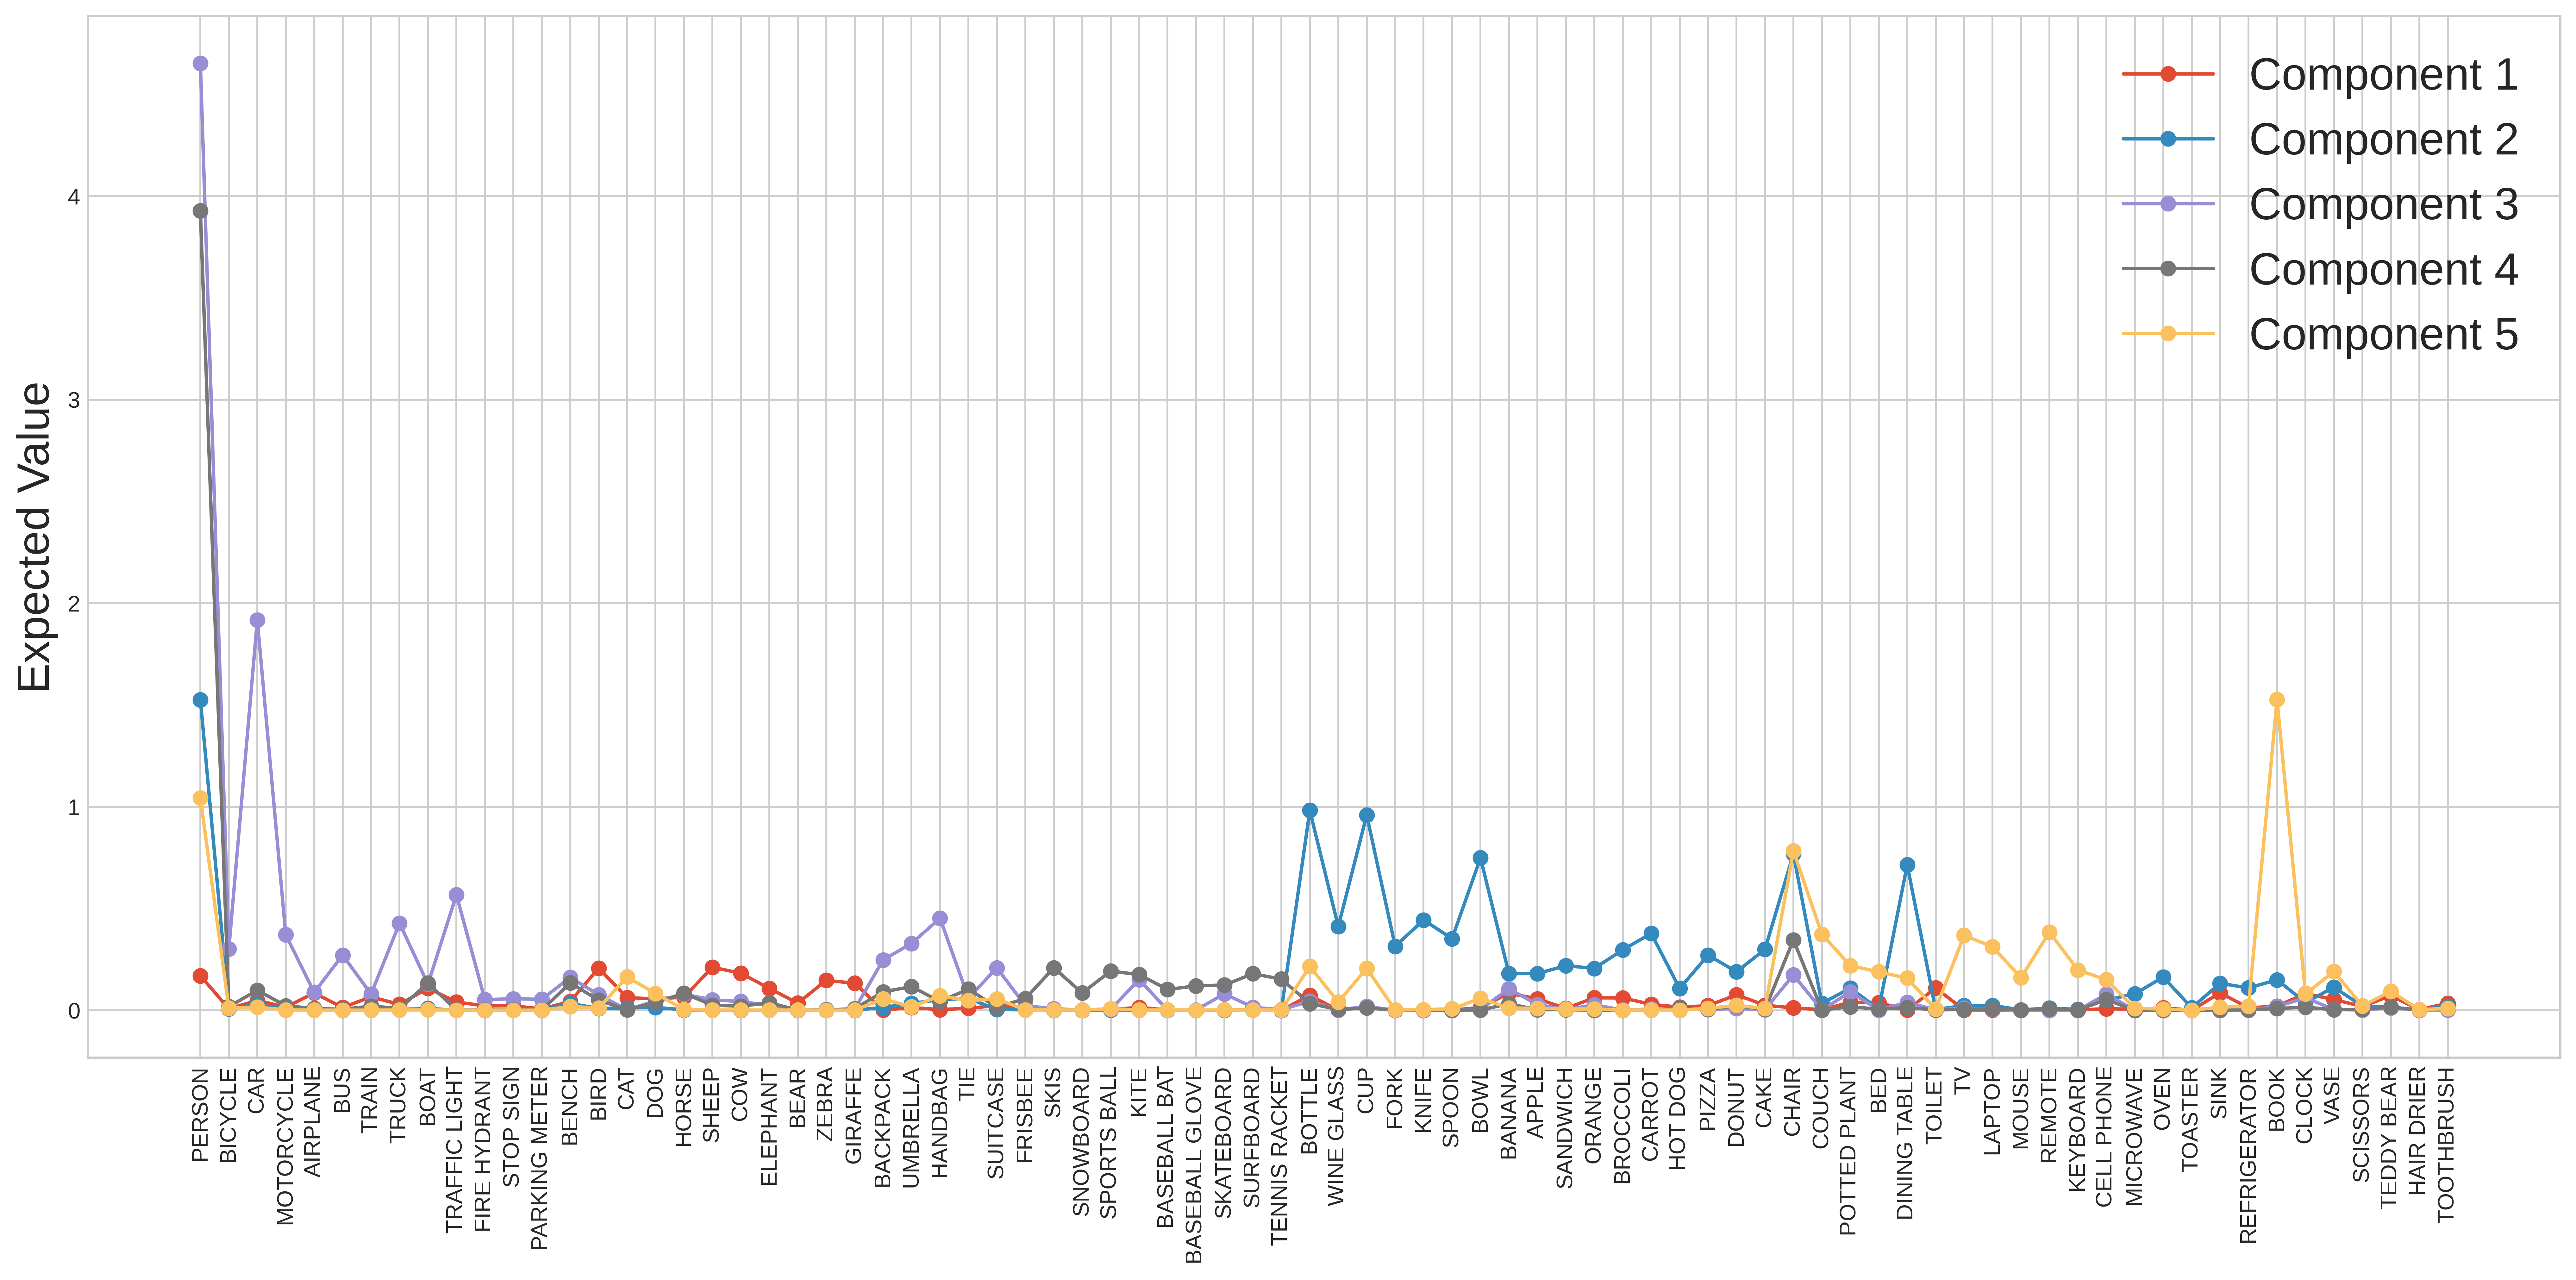

In [17]:
df_result_train = pd.read_csv("outputs/mixture/train-eval.csv")
i_best = df_result_train.bic.argmax()

params_best = torch.load(df_result_valid["directory"][i_best])
model = mixture.CategoricalMixture(params_best).cpu()

dataset_train = utils.dataset.ObjectCooccurrenceCOCODataset(
    "dataset/coco2017-cooccurences-train.csv"
)

max_value = model.dist.component_distribution.base_dist.probs.size(-1)
with torch.inference_mode():
    probs = model.dist.component_distribution.base_dist.probs
    expected_value = (torch.arange(max_value) * probs).sum(-1)
df_expected_value = pd.DataFrame(expected_value, columns=dataset_train.features.columns)
df_expected_value.columns = [
    col.split("-")[0].replace("[", "").replace("]", "").upper()
    for col in df_expected_value.columns
]

df_expected_value.to_csv(
    f"outputs/mixture/expected-value-{i_best+1:0=2d}.csv", index=False
)


fig = plt.figure(figsize=(16, 8), dpi=512)
ax = fig.add_subplot(1, 1, 1)

for i, row in enumerate(df_expected_value.iloc, 1):
    ax.plot(df_expected_value.columns, row, "o-", label=f"Component {i}")

ax.set_xticklabels(df_expected_value.columns, rotation="vertical")
ax.set_xlabel(None)
ax.set_ylabel("Expected Value", fontsize=20)

ax.legend(fontsize=20)
fig.tight_layout()
fig.savefig("outputs/mixture/component.pdf")

/tmp/ipykernel_559253/3419127733.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"Group {i+1}" for i in range(20)], rotation="vertical")


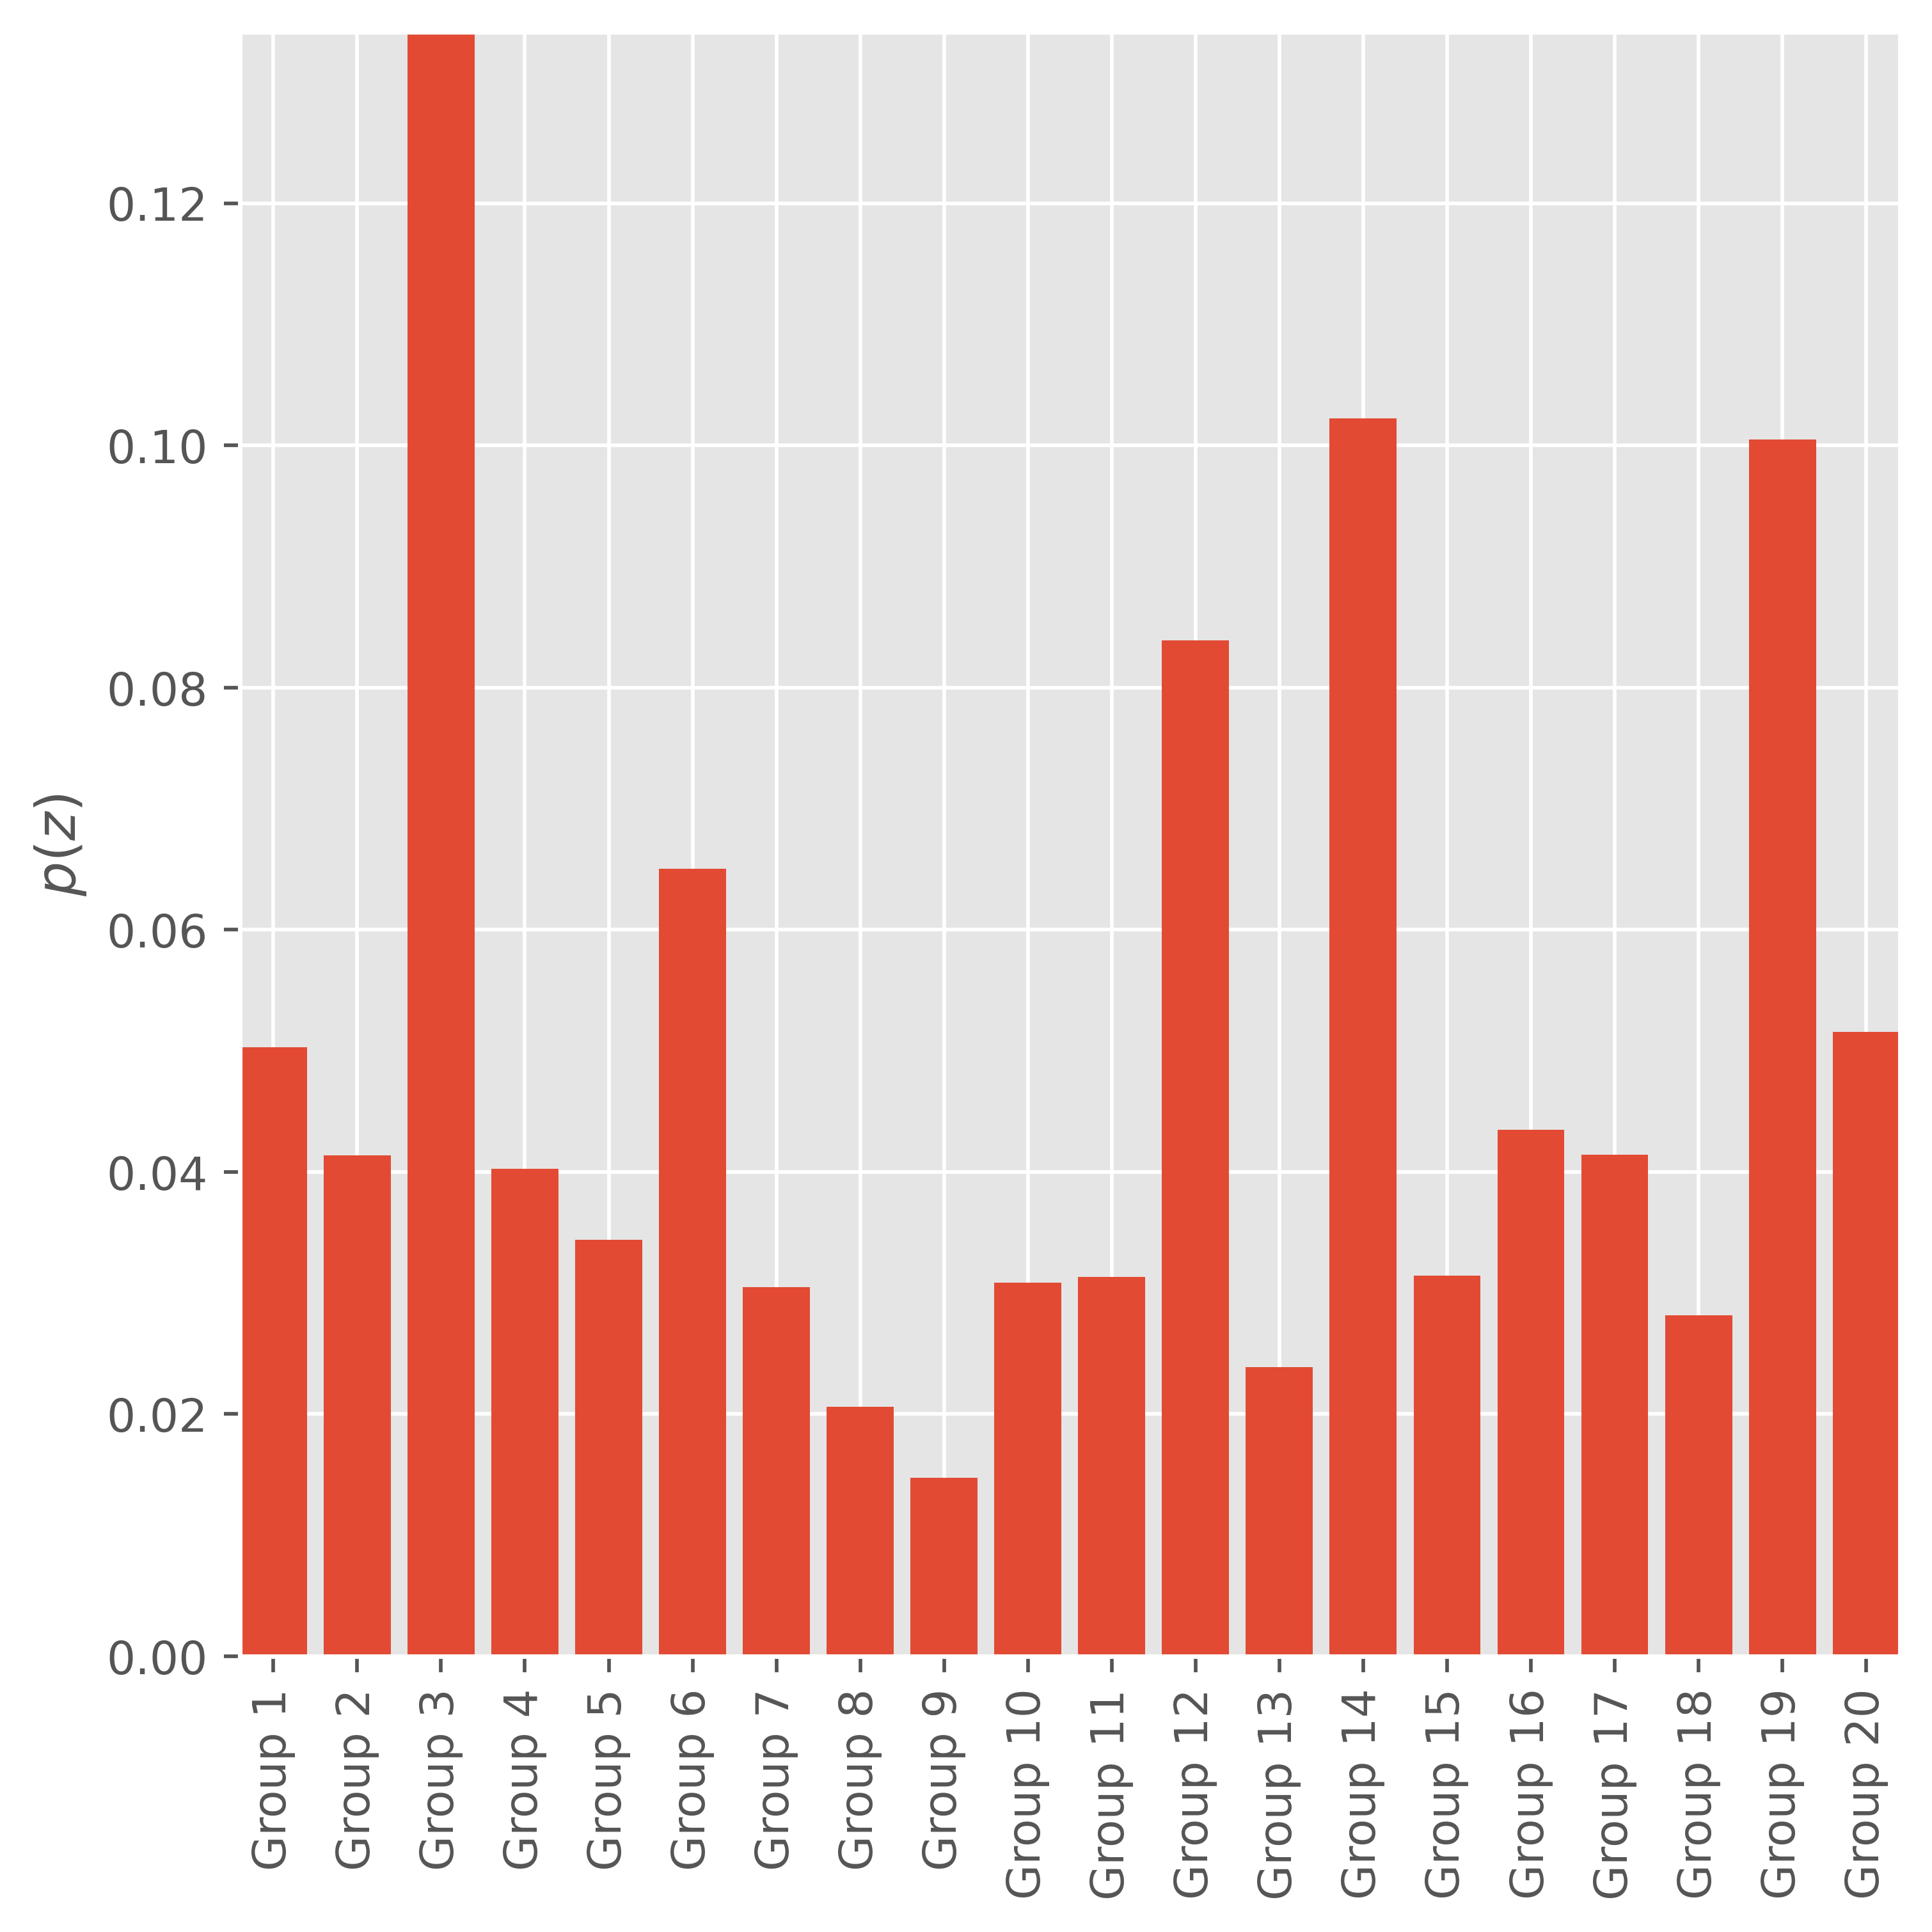

In [18]:
params_best = torch.load(df_result_valid["directory"][19])
model = mixture.CategoricalMixture(params_best).cpu()

fig = plt.figure(figsize=(6, 6), dpi=512)
ax = fig.add_subplot(1, 1, 1)

ax.bar(
    [f"Group {i+1}" for i in range(20)],
    model.dist.mixture_distribution.probs.detach(),
)

ax.set_xticklabels([f"Group {i+1}" for i in range(20)], rotation="vertical")
ax.set_ylabel("$p(z)$")

ax.autoscale(tight=True)
fig.tight_layout()
fig.savefig(f"outputs/mixture/prior-{20:0=2d}.pdf")

/tmp/ipykernel_559253/279645754.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"Group {i+1}" for i in range(i_best + 1)], rotation="vertical")


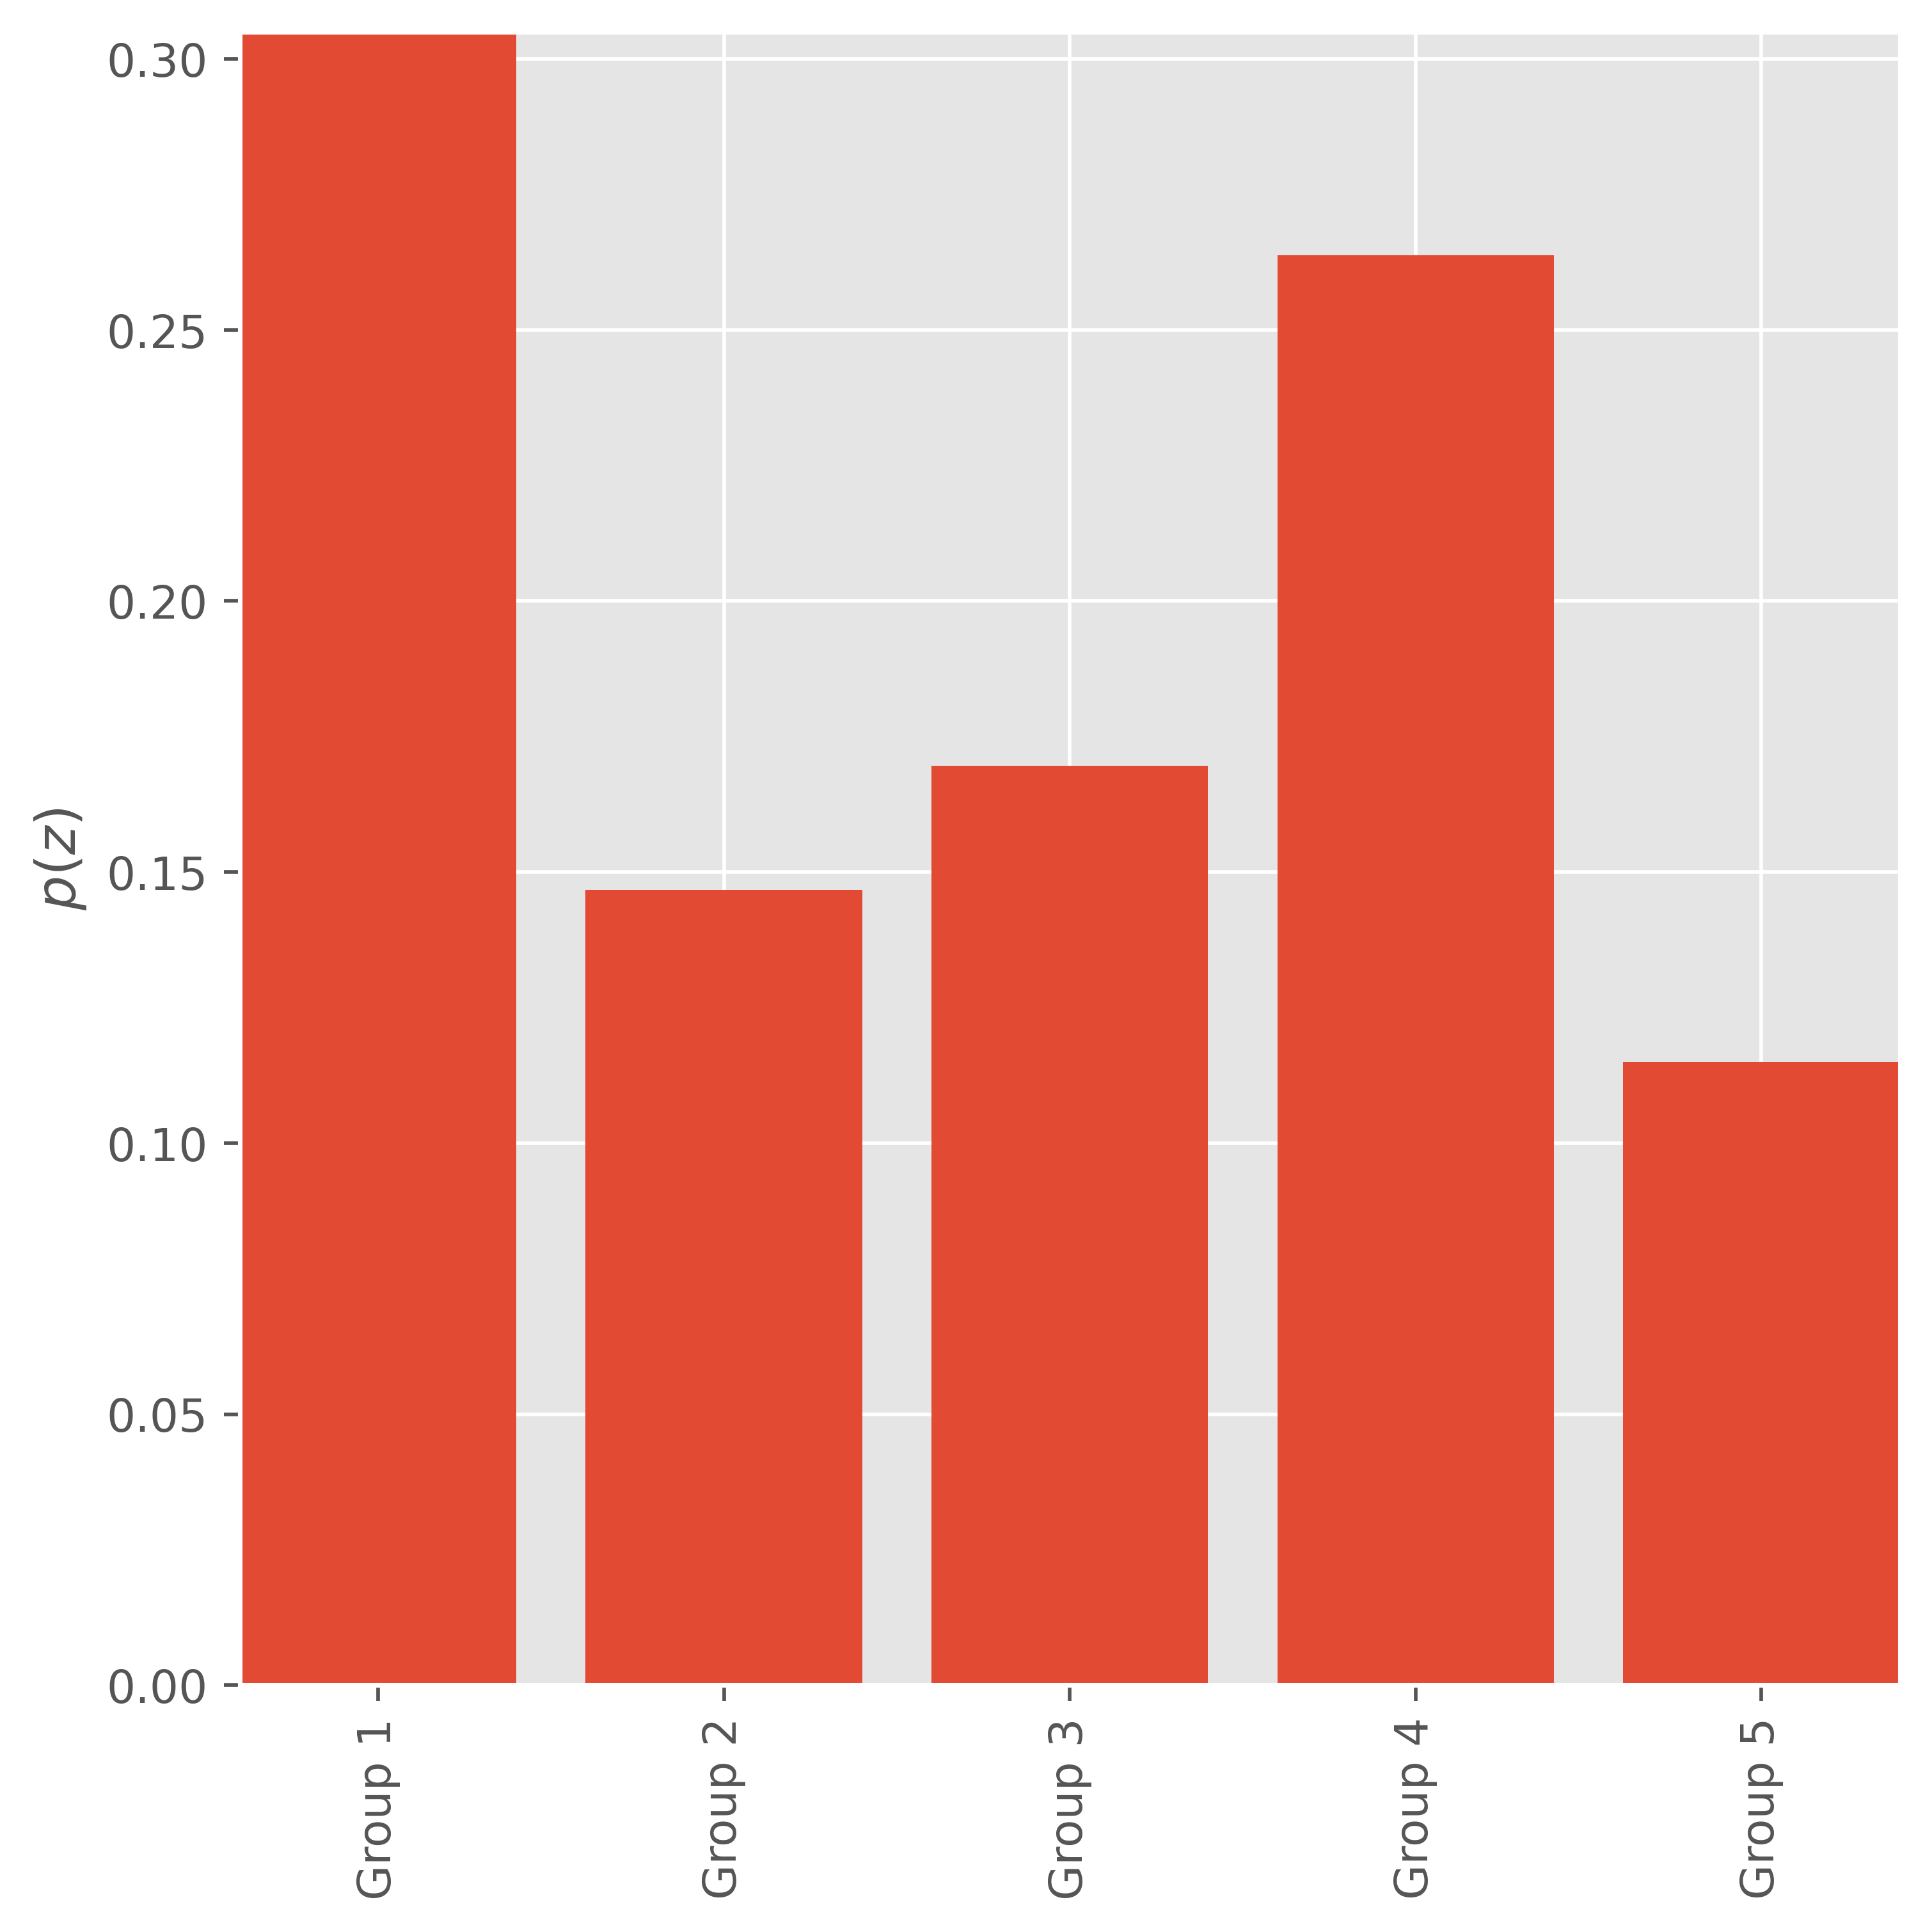

In [19]:
params_best = torch.load(df_result_valid["directory"][i_best])
model = mixture.CategoricalMixture(params_best).cpu()

fig = plt.figure(figsize=(6, 6), dpi=512)
ax = fig.add_subplot(1, 1, 1)

ax.bar(
    [f"Group {i+1}" for i in range(i_best + 1)],
    model.dist.mixture_distribution.probs.detach(),
)

ax.set_xticklabels([f"Group {i+1}" for i in range(i_best + 1)], rotation="vertical")
ax.set_ylabel("$p(z)$")

ax.autoscale(tight=True)
fig.tight_layout()
fig.savefig(f"outputs/mixture/prior-{i_best+1:0=2d}.pdf")

In [22]:
params = torch.load("outputs/mixture/mixture-01-params.pt")
model = mixture.CategoricalMixture(params).cpu()

device = "cpu"

dataloader_train = torch.utils.data.DataLoader(dataset_train, 512)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, 512)

total_params = sum(p.numel() for p in model.parameters())

total_train_ll = mixture.log_likelihood(dataloader_train, model, device)
avg_train_ll = total_train_ll / len(dataloader_train.dataset)
train_bic = total_train_ll - total_params / 2 * np.log(len(dataloader_train.dataset))

total_valid_ll = mixture.log_likelihood(dataloader_valid, model, device)
avg_valid_ll = total_valid_ll / len(dataloader_valid.dataset)

total_train_lp = mixture.log_posterior(dataloader_train, model, device)
avg_train_lp = total_train_lp / len(dataloader_train.dataset)

total_valid_lp = mixture.log_posterior(dataloader_valid, model, device)
avg_valid_lp = total_valid_lp / len(dataloader_valid.dataset)

print(f"Avg. Train NLL: {-avg_train_ll:.4f}")
print(f"Avg. Valid NLL: {-avg_valid_ll:.4f}")
print(f"Avg. Train NLP: {-avg_train_lp:.4f}")
print(f"Avg. Valid NLP: {-avg_valid_lp:.4f}")
print(f"BIC: {train_bic:,.4f}")

/home/zarizky/projects/neural-autoregressive-object-co-occurrence/mixture/__init__.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(index).to(inputs.device)


Avg. Train NLL: 14.8021
Avg. Valid NLL: 14.9431
Avg. Train NLP: 14.8021
Avg. Valid NLP: 14.9431
BIC: -1,764,455.7474


In [23]:
with open("outputs/overall/independent.json", "w", encoding="utf-8") as file:
    json.dump(
        dict(
            model="Independent",
            kind="Baseline",
            total_parameters=total_params,
            avg_train_nll=-avg_train_ll,
            avg_test_nll=-avg_valid_ll,
            avg_train_nlp=-avg_train_lp,
            avg_test_nlp=-avg_valid_lp,
            neg_bic=-train_bic,
        ),
        file,
        ensure_ascii=False,
        indent=4,
    )

In [24]:
params = torch.load("outputs/mixture/mixture-05-params.pt")
model = mixture.CategoricalMixture(params).cpu()

device = "cpu"

dataloader_train = torch.utils.data.DataLoader(dataset_train, 512)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, 512)

total_params = sum(p.numel() for p in model.parameters())

total_train_ll = mixture.log_likelihood(dataloader_train, model, device)
avg_train_ll = total_train_ll / len(dataloader_train.dataset)
train_bic = total_train_ll - total_params / 2 * np.log(len(dataloader_train.dataset))

total_valid_ll = mixture.log_likelihood(dataloader_valid, model, device)
avg_valid_ll = total_valid_ll / len(dataloader_valid.dataset)

total_train_lp = mixture.log_posterior(dataloader_train, model, device)
avg_train_lp = total_train_lp / len(dataloader_train.dataset)

total_valid_lp = mixture.log_posterior(dataloader_valid, model, device)
avg_valid_lp = total_valid_lp / len(dataloader_valid.dataset)

print(f"Avg. Train NLL: {-avg_train_ll:.4f}")
print(f"Avg. Valid NLL: {-avg_valid_ll:.4f}")
print(f"Avg. Train NLP: {-avg_train_lp:.4f}")
print(f"Avg. Valid NLP: {-avg_valid_lp:.4f}")
print(f"BIC: {train_bic:,.4f}")

Avg. Train NLL: 13.3492
Avg. Valid NLL: 13.5085
Avg. Train NLP: 12.6217
Avg. Valid NLP: 12.8048
BIC: -1,646,817.5170


In [25]:
with open("outputs/overall/mixture-05.json", "w", encoding="utf-8") as file:
    json.dump(
        dict(
            model="Mixture ($K = 5$)",
            kind="Baseline",
            total_parameters=total_params,
            avg_train_nll=-avg_train_ll,
            avg_test_nll=-avg_valid_ll,
            avg_train_nlp=-avg_train_lp,
            avg_test_nlp=-avg_valid_lp,
            neg_bic=-train_bic,
        ),
        file,
        ensure_ascii=False,
        indent=4,
    )

In [26]:
params = torch.load("outputs/mixture/mixture-20-params.pt")
model = mixture.CategoricalMixture(params).cpu()

device = "cpu"

dataloader_train = torch.utils.data.DataLoader(dataset_train, 512)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, 512)

total_params = sum(p.numel() for p in model.parameters())

total_train_ll = mixture.log_likelihood(dataloader_train, model, device)
avg_train_ll = total_train_ll / len(dataloader_train.dataset)
train_bic = total_train_ll - total_params / 2 * np.log(len(dataloader_train.dataset))

total_valid_ll = mixture.log_likelihood(dataloader_valid, model, device)
avg_valid_ll = total_valid_ll / len(dataloader_valid.dataset)

total_train_lp = mixture.log_posterior(dataloader_train, model, device)
avg_train_lp = total_train_lp / len(dataloader_train.dataset)

total_valid_lp = mixture.log_posterior(dataloader_valid, model, device)
avg_valid_lp = total_valid_lp / len(dataloader_valid.dataset)

print(f"Avg. Train NLL: {-avg_train_ll:.4f}")
print(f"Avg. Valid NLL: {-avg_valid_ll:.4f}")
print(f"Avg. Train NLP: {-avg_train_lp:.4f}")
print(f"Avg. Valid NLP: {-avg_valid_lp:.4f}")
print(f"BIC: {train_bic:,.4f}")

Avg. Train NLL: 12.6865
Avg. Valid NLL: 12.8932
Avg. Train NLP: 11.4260
Avg. Valid NLP: 11.7301
BIC: -1,771,756.1819


In [27]:
with open("outputs/overall/mixture-20.json", "w", encoding="utf-8") as file:
    json.dump(
        dict(
            model="Mixture ($K = 20$)",
            kind="Baseline",
            total_parameters=total_params,
            avg_train_nll=-avg_train_ll,
            avg_test_nll=-avg_valid_ll,
            avg_train_nlp=-avg_train_lp,
            avg_test_nlp=-avg_valid_lp,
            neg_bic=-train_bic,
        ),
        file,
        ensure_ascii=False,
        indent=4,
    )